# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
"""
you will be forecasting real estate prices of various zip codes 

What are the top 5 best zip codes for us to invest in?

Should your recommendation be focused on profit margins only? 
What about risk? 
What sort of time horizon are you predicting against? 
Your recommendation will need to detail your rationale and answer any sort of lingering questions like these 
    in order to demonstrate how you define "best".

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), 
    you need to start with a definition of "best investment". 
    Consider additional metrics like risk vs. profitability, or ROI yield.


"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#pd.set_option('display.max_columns', None)  
zillow = pd.read_csv('zillow_data.csv')
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
all_zipcodes = melt_data(zillow)

In [6]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [7]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [8]:
kings = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY') &
                    (all_zipcodes['MeanValue']> 300000.0)]
kings

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
427073,62026,11215,New York,NY,New York,Kings,107,1998-09-01,302800.0
441796,62026,11215,New York,NY,New York,Kings,107,1998-10-01,308200.0
456519,62026,11215,New York,NY,New York,Kings,107,1998-11-01,314100.0
471242,62026,11215,New York,NY,New York,Kings,107,1998-12-01,321000.0
485965,62026,11215,New York,NY,New York,Kings,107,1999-01-01,327800.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [9]:
kings['Zipcode'].nunique()

28

In [10]:
kings.index

Int64Index([ 427073,  441796,  456519,  471242,  485965,  500631,  500688,
             515354,  515411,  530077,
            ...
            3887238, 3887295, 3887311, 3887347, 3887572, 3887683, 3888027,
            3888306, 3888406, 3890600],
           dtype='int64', length=5193)

### Visualization

In [11]:
"""
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

"""



kings_1 = zillow.copy()
#kings_1 = kings_1.set_index('Month')
kings_plot = kings_1[(kings_1['CountyName']=='Kings') & (kings_1['State']== 'NY')]


In [12]:
kings_plot = kings_plot.drop(["RegionID", "City", "State", "Metro", "CountyName", "SizeRank"], axis=1)
kings_plot.head()

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
10,11226,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
13,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
47,11230,230100.0,230800.0,231500.0,232100.0,232800.0,233600.0,234700.0,235900.0,237500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400
49,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800
53,11212,125000.0,125000.0,125000.0,125000.0,125100.0,125100.0,125000.0,124800.0,124600.0,...,380000,387000,394600,401500,407900,414900,422300,426300,427100,428400


In [13]:
kings_plot = kings_plot.transpose()

In [14]:
new_header=kings_plot.iloc[0] ##grab all first row data for the column headers
kings_plot = kings_plot[1:] ## take all rows after first row
kings_plot.columns=new_header ## assign all column headers to be equal to row 0 data

In [15]:
kings_plot.head()

Zipcode,11226.0,11235.0,11230.0,11209.0,11212.0,11214.0,11221.0,11229.0,11234.0,11215.0,...,11219.0,11203.0,11220.0,11216.0,11210.0,11224.0,11222.0,11205.0,11217.0,11228.0
1996-04,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,...,213200.0,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,NaN,NaN,219300.0
1996-05,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,...,212600.0,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,NaN,NaN,219600.0
1996-06,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,...,211900.0,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,NaN,NaN,219900.0
1996-07,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,...,211300.0,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,NaN,NaN,220200.0
1996-08,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,...,210800.0,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,NaN,NaN,220600.0


In [16]:
kings_plot.index

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=265)

In [17]:
"""
11217 > 3000000 
11238 > 2700000
11205 > 2500000
11215 > 2000000
11222 > 1700000    
11211 > 1600000      
"""
mil_2 = kings[kings['MeanValue']> 1600000.00]
mil_2.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
2106923,62028,11217,New York,NY,New York,Kings,1535,2008-03-01,1603400.0
2121646,62028,11217,New York,NY,New York,Kings,1535,2008-04-01,1619500.0
2136369,62028,11217,New York,NY,New York,Kings,1535,2008-05-01,1629000.0
2151092,62028,11217,New York,NY,New York,Kings,1535,2008-06-01,1629000.0
2165815,62028,11217,New York,NY,New York,Kings,1535,2008-07-01,1621800.0
2180538,62028,11217,New York,NY,New York,Kings,1535,2008-08-01,1614600.0
2195261,62028,11217,New York,NY,New York,Kings,1535,2008-09-01,1609300.0
2209984,62028,11217,New York,NY,New York,Kings,1535,2008-10-01,1602900.0
2651674,62028,11217,New York,NY,New York,Kings,1535,2011-04-01,1605300.0
2666397,62028,11217,New York,NY,New York,Kings,1535,2011-05-01,1612100.0


In [18]:
mil_2['Zipcode'].value_counts()

11217    93
11205    57
11238    56
11215    51
11222    17
11211     1
Name: Zipcode, dtype: int64

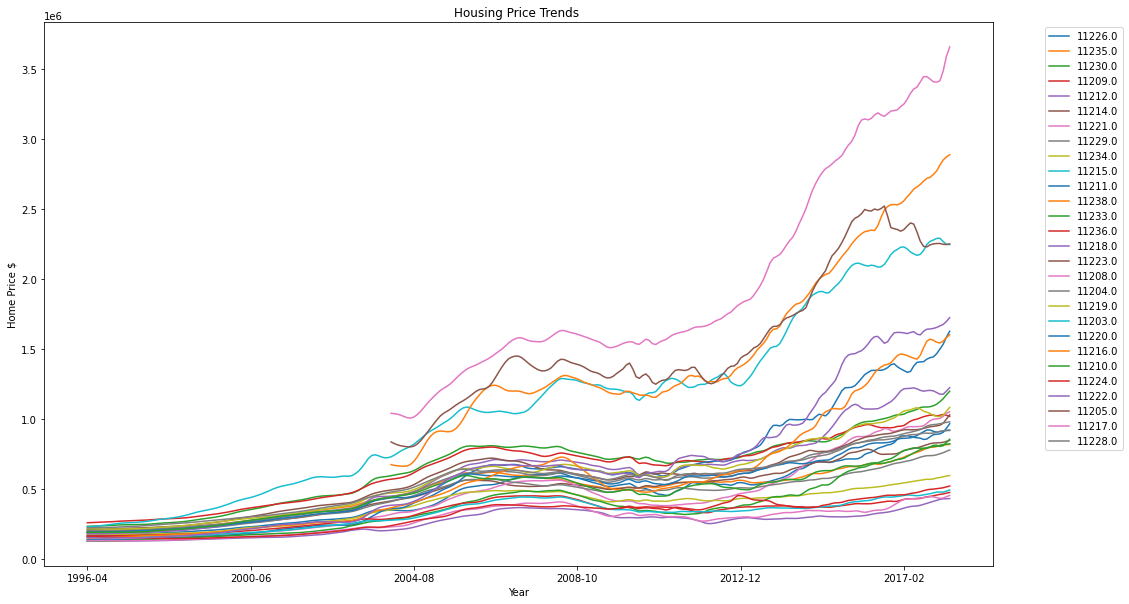

In [19]:
kings_plot.plot(figsize=(17,10))
plt.title("Housing Price Trends ")
#ax.set(title=f'Baltimore Crime Rates - {kings_plot.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Price $')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

### Zipcode: 11217

In [20]:
#make loop
brooklyn_zips = {}

for zipcode in kings['Zipcode'].unique(): 
    all_zips = kings[kings['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    brooklyn_zips[zipcode] = all_zips

In [21]:
brooklyn_zips[11217]

Month
2004-01-01    1037600.0
2004-02-01    1035300.0
2004-03-01    1031400.0
2004-04-01    1024000.0
2004-05-01    1014300.0
                ...    
2017-12-01    3404100.0
2018-01-01    3413800.0
2018-02-01    3482900.0
2018-03-01    3588100.0
2018-04-01    3656000.0
Freq: MS, Name: MeanValue, Length: 172, dtype: float64

<AxesSubplot:xlabel='Month'>

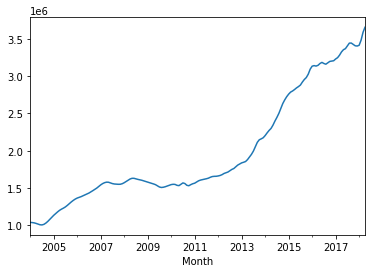

In [22]:
brooklyn_zips[11217].plot()

In [23]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

ADF statistic: 0.5835457591974271
p-value: 0.9872029599039591
Critical Values:
	1% : -3.472703119504854
	5% : -2.880131672353732
	10% : -2.5766826861130268


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.583546,0.987203,14,157,False


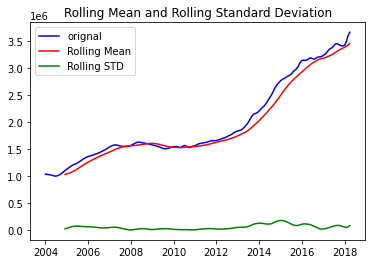

In [24]:
stationary_test(brooklyn_zips[11217])

###  Zipcode:  11238

In [25]:
brooklyn_zips[11238]

Month
2004-01-01     671200.0
2004-02-01     665400.0
2004-03-01     662500.0
2004-04-01     660200.0
2004-05-01     659200.0
                ...    
2017-12-01    2768900.0
2018-01-01    2810700.0
2018-02-01    2848100.0
2018-03-01    2869600.0
2018-04-01    2885300.0
Freq: MS, Name: MeanValue, Length: 172, dtype: float64

ADF statistic: 1.1044978183105407
p-value: 0.9952548273867158
Critical Values:
	1% : -3.4724305215713156
	5% : -2.8800127935315465
	10% : -2.576619230892485


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,1.104498,0.995255,13,158,False


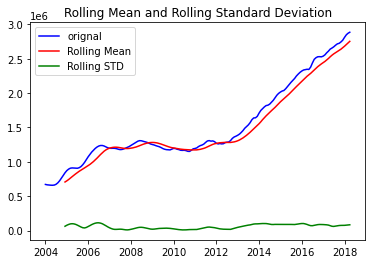

In [26]:
stationary_test(brooklyn_zips[11238])

### Zipcode:  11215

ADF statistic: -0.1839886492128848
p-value: 0.9404034113367092
Critical Values:
	1% : -3.4604283689894815
	5% : -2.874768966942149
	10% : -2.57382076446281


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-0.183989,0.940403,15,220,False


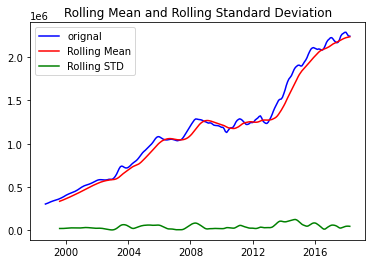

In [27]:
stationary_test(brooklyn_zips[11215])

### Removing Trend
#### Log-Transformation (np.log)

ADF statistic: 0.05127416816325229
p-value: 0.9625725244019687
Critical Values:
	1% : -3.4724305215713156
	5% : -2.8800127935315465
	10% : -2.576619230892485


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.051274,0.962573,13,158,False


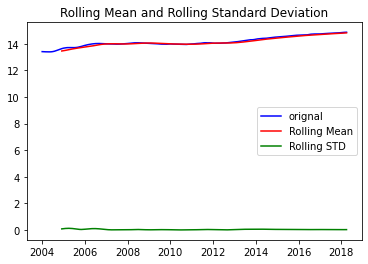

In [28]:
## Log Transform
ts3 = np.log(brooklyn_zips[11238])
#ts3.plot()
stationary_test(ts3)

#### Differencing

ADF statistic: -1.7193120702078397
p-value: 0.42119078809265625
Critical Values:
	1% : -3.4724305215713156
	5% : -2.8800127935315465
	10% : -2.576619230892485


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.719312,0.421191,12,158,False


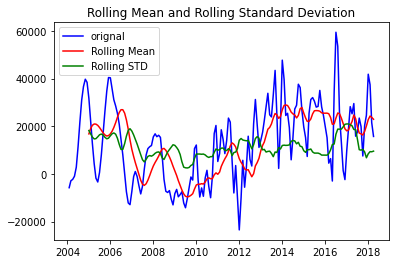

In [29]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = brooklyn_zips[11238].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

ADF statistic: -1.5289059368844071
p-value: 0.5191666242725915
Critical Values:
	1% : -3.472703119504854
	5% : -2.880131672353732
	10% : -2.5766826861130268


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.528906,0.519167,12,157,False


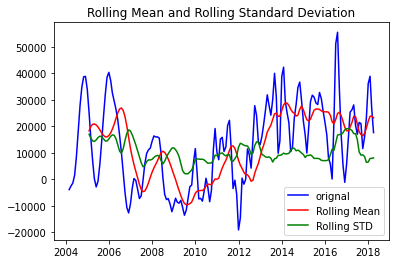

In [30]:
## Subtract Rolling mean
ts2 = (brooklyn_zips[11238] - brooklyn_zips[11238].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

ADF statistic: -0.993228194047712
p-value: 0.7557261417041574
Critical Values:
	1% : -3.4724305215713156
	5% : -2.8800127935315465
	10% : -2.576619230892485


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-0.993228,0.755726,13,158,False


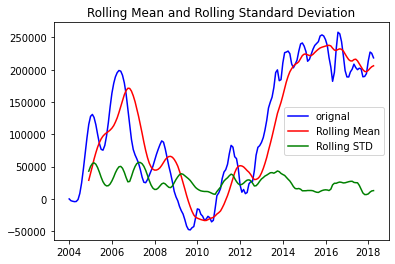

In [31]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (brooklyn_zips[11238] - brooklyn_zips[11238].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

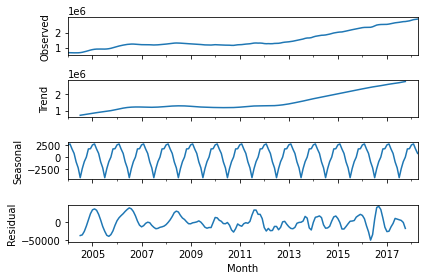

In [32]:
"""
it will identfies patterns, trends in ts and separate them into 3 new ts.
residual-what was left over after removing all the other components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(brooklyn_zips[11238])#,model='mul')
decomp.plot();

ADF statistic: -6465802609431888.0
p-value: 0.0
Critical Values:
	1% : -3.4718957209472654
	5% : -2.8797795410156253
	10% : -2.5764947265625


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-6.465803e+15,0.0,11,160,True


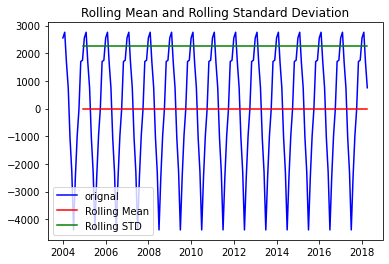

In [33]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

ADF statistic: 2.0266796644541563
p-value: 0.9987066314715032
Critical Values:
	1% : -3.476273058920005
	5% : -2.881687616548444
	10% : -2.5775132580261593


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,2.02668,0.998707,14,145,False


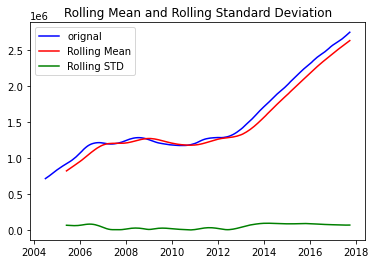

In [34]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

ADF statistic: -5.711706501213588
p-value: 7.274262505225111e-07
Critical Values:
	1% : -3.473829775724492
	5% : -2.880622899711496
	10% : -2.5769448985432954


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-5.711707,7.274263e-07,6,153,True


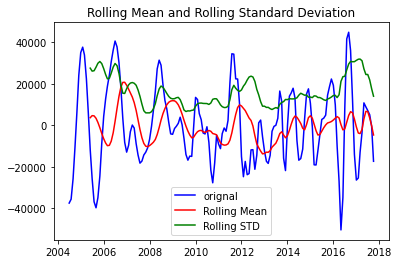

In [35]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [36]:
decomp.resid.dropna()

Month
2004-07-01   -37396.909341
2004-08-01   -35524.290293
2004-09-01   -25726.076007
2004-10-01   -10735.004579
2004-11-01     6342.536630
                  ...     
2017-06-01     8938.369963
2017-07-01     7190.590659
2017-08-01     5159.043040
2017-09-01     -505.242674
2017-10-01   -17268.337912
Freq: MS, Name: MeanValue, Length: 160, dtype: float64

### GridSearch 

#### Find the values of ARIMA(p,d,q)(P,D,Q)s

In [37]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#### Identify the set of parameters that will produce the best fitting model to time series dataset.

In [38]:
"""
(AIC) is an estimator of the relative quality of statistical models for a given set of data. 
Given a collection of models for the data, AIC estimates the quality of each model, relative to each of 
    the other models. AIC provides a means for model selection.

Model that fits the data very well while using lots of features will be assigned a larger AIC score than a model
    that uses fewer features to achieve the same goodness-of-fit. 
    We are interested in finding the model that yields the lowest AIC value. 

"""
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
def gridsearch_pdq(pdq, pdqs, df):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
                
            except:
                continue
    
    
    
    # Find the parameters with minimal AIC value
#     ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
#     ans_df.loc[ans_df['aic'].idxmin()]

    
    return ans            

In [39]:
gs_pdq = gridsearch_pdq(pdq, pdqs,brooklyn_zips[11238])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5379.794046293979
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4915.309801670082
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4343.637564975837
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =3978.0723883036417
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4217.288710901857
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4167.380426360786
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =3900.8703875479687
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =3871.7512607790522
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5227.055782584166
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =5154.756317471596
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4426.84063014958
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3873.007070257797
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =5284.1846007114755
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =5152.322271860577
ARIMA (0, 0, 1) x

In [40]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(gs_pdq, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic            3124.4
Name: 63, dtype: object

### Creating a SARIMA TS Model

In [41]:
"""
Using grid search, we have identified the set of parameters that produces the best fitting model 
    to our time series data. 

coef column above shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.

each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

model diagnostics-The purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.
where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.



# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(brooklyn_zips[11238], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
"""
def fit_ARIMA(df, order=None, seasonal_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    
    return output

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6534      0.066      9.888      0.000       0.524       0.783
ma.L1          0.3252      0.040      8.144      0.000       0.247       0.404
ar.S.L12      -0.3687      0.099     -3.735      0.000      -0.562      -0.175
ma.S.L12      -0.0210      0.077     -0.273      0.785      -0.172       0.130
sigma2      1.265e+08    1.8e-10   7.04e+17      0.000    1.27e+08    1.27e+08


MODEL DIAGNOSTICS


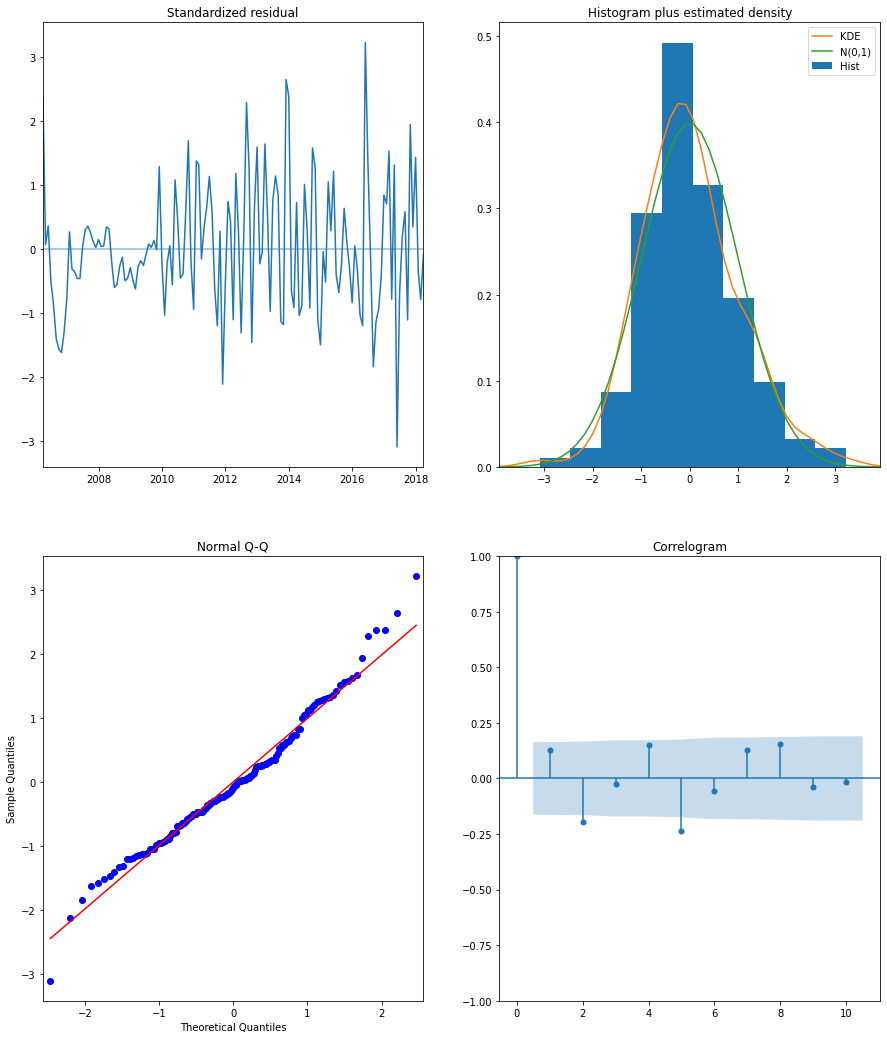

In [42]:
output_summ = fit_ARIMA(brooklyn_zips[11238], order=(1,1,1), seasonal_order=(1,1,1,12))

### Validating the Model

In [43]:
brooklyn_zips[11238].head()

Month
2004-01-01    671200.0
2004-02-01    665400.0
2004-03-01    662500.0
2004-04-01    660200.0
2004-05-01    659200.0
Freq: MS, Name: MeanValue, dtype: float64

In [44]:
"""
start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

plot the real and forecasted values of the CO2 time series to assess how well we did

"""
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [45]:
pred_conf

,lower MeanValue,upper MeanValue
Month,,
2016-01-01,2.308243e+06,2.352339e+06
2016-02-01,2.313439e+06,2.357535e+06
2016-03-01,2.322009e+06,2.366106e+06
2016-04-01,2.336514e+06,2.380610e+06
2016-05-01,2.335347e+06,2.379444e+06
2016-06-01,2.320028e+06,2.364125e+06
2016-07-01,2.400715e+06,2.444812e+06
2016-08-01,2.471001e+06,2.515098e+06
2016-09-01,2.513998e+06,2.558094e+06


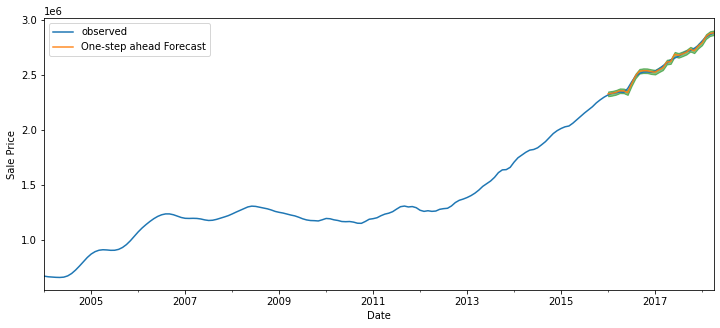

In [46]:
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = brooklyn_zips[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()

In [47]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 = brooklyn_zips[11238]['2004':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 205510949.29
The Root Mean Squared Error of our forecasts is 14335.65


In [48]:
"""
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()
"""
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

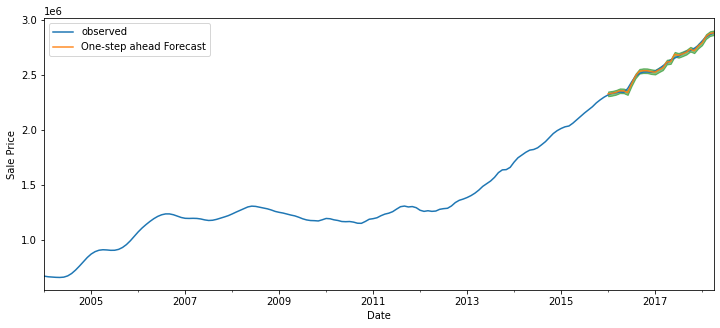

In [49]:
# Plot the dynamic forecast with confidence intervals.
plt.figure(figsize=(12,5))
# Plot observed values
ax = brooklyn_zips[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


### AUTOARIMA Model

In [50]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [51]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm

from sklearn.model_selection import train_test_split


In [52]:
# # Load/split your data
# y = pm.datasets.load_wineind()
# train, test = train_test_split(y, train_size=150)


In [53]:
from pmdarima import auto_arima

In [54]:
"""
stepwise-stepping through different combinations
trace=let's us see different models that auto arima tried out
reports back aic and bic
lot's similar aic values, it figures out that it's no longer worth to increase order of more complex models
    all the way to max_p=6 value
    instead it say these ar estaying the same. No longer worth it to increase aic b/c it' something we're trying to 
    minimize.
    
"""
stepwise_fit = auto_arima(brooklyn_zips[11238],start_p=0, start_q=0,max_p=6,max_q=3, trace=True)

Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3592.639, BIC=3598.911, Fit time=0.031 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3594.794, BIC=3604.201, Fit time=0.052 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3595.153, BIC=3604.561, Fit time=0.065 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3597.361, BIC=3609.904, Fit time=0.263 seconds
Total fit time: 0.420 seconds


In [55]:
"""
gives summary of bet performing model that autoarima thinks we should use.
"""
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  172
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1794.320
Date:                Tue, 03 Nov 2020   AIC                           3592.639
Time:                        14:18:43   BIC                           3598.911
Sample:                             0   HQIC                          3595.184
                                - 172                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    126.4706    726.215      0.174      0.862   -1296.885    1549.826
sigma2      8.616e+07   7.31e+06     11.780      0.000    7.18e+07    1.01e+08
===================================================================================
Ljung-Box (Q):                      128.09   Jarque-Bera (JB):                17.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.94   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
"""
create an arima model using statsmodel of order 0,2,0
train tst split
forecasting
don't need to read auto_correlation and partial auto_correlation plots

defaults are 2,2
0. or 1. p,q
seasonal by default=True
see rtace results of different arima models
m= number of periods per season
    there is normal differencing and seasonal differencing
    4 for quarterly data 
    12 for monthly data
    1 for annual for non-seasonal data
    
 abd sarimax model   
"""
# def autoarima_model(df):
#     stepwise_fit_1 = auto_arima(df,start_p=0, start_q=0,max_p=6,max_q=6, seasonal=True, 
#                             trace=True,m=12)
    
#     print('\n')
#     print(stepwise_fit_1.summary())
#     return stepwise_fit_1

"\ncreate an arima model using statsmodel of order 0,2,0\ntrain tst split\nforecasting\ndon't need to read auto_correlation and partial auto_correlation plots\n\ndefaults are 2,2\n0. or 1. p,q\nseasonal by default=True\nsee rtace results of different arima models\nm= number of periods per season\n    there is normal differencing and seasonal differencing\n    4 for quarterly data \n    12 for monthly data\n    1 for annual for non-seasonal data\n    \n abd sarimax model   \n"

In [57]:
#autoarima_model(brooklyn_zips[11238])

In [58]:
"""
this is whatwe should apss into statsmodels when performing forecasting
returns best performing model

"""
#stepwise_fit_1.summary()

'\nthis is whatwe should apss into statsmodels when performing forecasting\nreturns best performing model\n\n'

In [59]:
#train test split
brook_zip = brooklyn_zips[11238]

In [60]:
"""
birth_train = f_births[0:330]
birth_test = f_births[330:365]

shampoo_train = shampoo[0:25]
shampoo_test = shampoo[25:36]
"""

# train = brooklyn_zips[11238][0:138]
# test = brooklyn_zips[11238][138:172]

'\nbirth_train = f_births[0:330]\nbirth_test = f_births[330:365]\n\nshampoo_train = shampoo[0:25]\nshampoo_test = shampoo[25:36]\n'

In [61]:
# print(train.shape)
# print(test.shape)

In [62]:
# plt.plot(train)
# plt.plot(test)

### Build AutoArima Model

In [63]:
"""
AIC and BIC depend on log liklihood

"""
# arima_model = auto_arima(brooklyn_zips[11238],start_p=1, start_q=1,
           
#                             start_P=0, start_Q=0, D=1,max_P=5,max_D=5,max_Q=5, m=12,
#                             seasonal=True, error_action='warn',trace=True, stepwise=True,
#                            random_state=20, n_fits=50)
# arima_model = auto_arima(brooklyn_zips[11238],start_p=1, start_q=1, 
#                              max_p=3,max_q=3,m=12,d=1, D=1, trace=True,  error_action='ignore',
#                              suppress_warnings=True, stepwise=True)

'\nAIC and BIC depend on log liklihood\n\n'

In [64]:
"""
create an arima model using statsmodel of order 0,2,0
train tst split
forecasting
don't need to read auto_correlation and partial auto_correlation plots

defaults are 2,2
0. or 1. p,q
seasonal by default=True
see rtace results of different arima models
m= number of periods per season
    there is normal differencing and seasonal differencing
    4 for quarterly data 
    12 for monthly data
    1 for annual for non-seasonal data
    
 abd sarimax model   

"""
def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 1, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=1, D=1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    print(autoarima_model.summary())
    
    #autoarima_model.plot_diagnostics(figsize=(12,10))
    
    return autoarima_model

    #autoarima_model.summary()

In [65]:
sf = arima_model(brooklyn_zips[11238])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3732.039, BIC=3750.452, Fit time=1.535 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3607.507, BIC=3613.645, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3675.816, BIC=3688.091, Fit time=0.473 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3630.452, BIC=3642.728, Fit time=0.305 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3602.776, BIC=3611.982, Fit time=0.127 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3603.784, BIC=3616.059, Fit time=0.423 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=3605.012, BIC=3620.356, Fit time=2.808 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3630.661, BIC=3642.936, Fit time=0.165 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3729.275, BIC=3744.620, Fit time=0.512 seconds
Fit ARIMA: order=(0, 1, 0) s

In [66]:
sf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  172
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1798.388
Date:                            Tue, 03 Nov 2020   AIC                           3602.776
Time:                                    14:18:50   BIC                           3611.982
Sample:                                         0   HQIC                          3606.514
                                            - 172                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    463.5220   1652.206      0.281      0.779   -2774.743    3701.787
ar.S.L12      -0.0764      0.016     -4.869      0.000      -0.107      -0.046
sigma2      4.076e+08      0.010   3.94e+10      0.000    4.08e+08    4.08e+08
===================================================================================
Ljung-Box (Q):                      230.09   Jarque-Bera (JB):                 4.27
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               0.69   Skew:                            -0.26
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.11e+26. Standard errors may be unstable.
"""

In [67]:
"""
AIC- which estimates the relative amount of information lost by a given model
a lower AIC value is preferred

"""
print(sf.aic())

3602.7755945579493


In [68]:
# sf.plot_diagnostics()
# plt.figure(figsize=(12,10))

### Train Test Split

In [69]:
def train_test(X, perct=None): 
    train_size = int(len(X) * perct)
    train, test = X[0:train_size], X[train_size: len(X)]
    print('Observations:{}'.format(len(X)))
    print('Train Set: {}'.format(len(train)))   
    print('Test Set: {}'.format(len(test))) 

    return train, test

In [70]:
train, test = train_test(brooklyn_zips[11238], perct=0.80)

Observations:172
Train Set: 137
Test Set: 35


In [71]:
len(train)

137

### Forecasting on Test Data

In [72]:
#length of test data
future_forecast = sf.predict(n_periods=35)
print(future_forecast)

[2912779.53638482 2930464.66247822 2951722.97215751 2977887.04701116
 2998479.21942877 3006886.03733686 3026205.02616858 3049204.92935178
 3089022.68090009 3125525.74309149 3148001.34829385 3164890.95841175
 3192988.44150293 3210993.00880423 3232435.23469015 3258851.57241055
 3279846.72084287 3288647.75237334 3308505.24222103 3332090.96333874
 3372523.74079597 3409558.87824897 3432423.43963832 3449685.64947754
 3478199.42471151 3496643.09902845 3518534.79015017 3545395.36934879
 3566823.24020415 3576057.66387016 3596337.51792073 3620341.98679377
 3661191.27963129 3698649.27240968 3721947.62776209]


<AxesSubplot:xlabel='Month'>

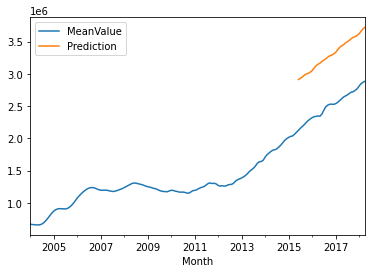

In [73]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([brooklyn_zips[11238],future_forecast],axis=1).plot()

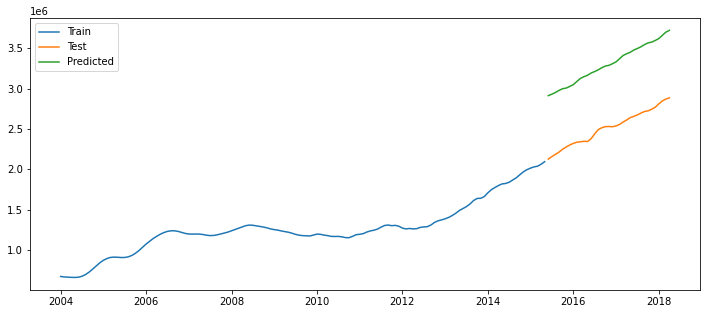

In [74]:
plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
plt.plot(test,label='Test')
plt.plot(future_forecast,label='Predicted')
plt.legend()

In [75]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test, future_forecast)
rmse = sqrt(mse)
print(rmse)

792321.3704869068


#### Return on Investment

In [76]:
investment = 40000
rent = 700
loss = 1000  #cost of 1000 per year

def roi(investment, rent, loss):
    """
    return on investment is calcualted by net_profit / investment * 100
    12 = # of months in year 
    investment part doesn't need to be touched investment amount is just capital cost of building
    """
    netprofit = rent * 12 - loss
    ROI = (netprofit / investment) * 100
    print(ROI)
    
#roi(investment, rent, loss) 
#calculated return on investment for these parameters
roi(investment, rent, loss)   

18.5
